<font size=6><b>**Тестовое от Работа.ру**</b></font>
    
<font size=6><b>**Бинарная классификации откликов**</b></font>

<font size=4><b>Часть 3. Modeling.</b></font>

***

# Постановка задачи

**Заказчик**  
Работа.ру

**Цель**  
Автоматизировать труд рекрутеров в части просмотра и оценки резюме, что позволит существенно сэкономить ресурсы по подбору персонала.

**Задачи**  

1. Проанализировать датасет и провести обработку данных.
1. Сгенерировать новые признаки.
1. *На основе результатов предыдущего шага определить модель для предсказания  факта приглашения работодателем откликнувшегося соискателя на собеседование.*

**Исходные данные**  

Данные представлены в виде датасета с основными параметрами вакансий\резюме (название, описание, требования по опыту работы, графику работы, знанию иностранных языков, перечень навыков и т. д.). 
Вакансии и резюме представлены парами.  
Целевая переменная первой задачи – откликнется (1) или не откликнется (0) соискатель с данным резюме на данную вакансию.  
Целевая переменная второй задачи – пригласит (1) или не пригласит (0) работодатель откликнувшегося соискателя на собеседование.


# Подготовка окружения

Загрузим библиотеки, необходимые для выполнения проекта.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from tqdm.notebook import tqdm

In [2]:
try:
    from catboost import CatBoostClassifier, Pool, cv 
except Exception:
    !pip install catboost
    from catboost import CatBoostClassifier, Pool, cv

In [3]:
try:
    import optuna
except Exception:
    ! pip install optuna
    import optuna

In [4]:
try:
    import shap
except Exception:
    !pip install shap
    import shap

In [5]:
# автоформатирование Jupyter lab
try:
    %load_ext lab_black
except:
    !pip install nb_black
    %load_ext lab_black

In [6]:
# отображение таблиц без ограничения на количество столбцов
pd.set_option("display.max_columns", None)

Загрузим сами данные.

In [7]:
try:
    df = pd.read_csv("/content/vacancy_resume_data_preprocesed.csv")  # Colab
except FileNotFoundError:
    df = pd.read_csv("vacancy_resume_data_preprocesed.csv")  # Local

In [8]:
df.head()

,resume_id,vacancy_id,birth_date,resume_salary_from,resume_city_id,resume_city_search_job,resume_is_leaving,resume_offer_education_id,resume_is_foreign_language,resume_is_upload_photo,percentage_of_resume_completion,resume_offer_experience_year_count,resume_region_id,vacancy_operating_schedule_id,vacancy_salary_from,vacancy_salary_to,vacancy_offer_education_id,vacancy_offer_experience_year_count,vacany_company_id,vacancy_is_agency,vacancy_city_id,vacancy_offer_experience_year_id,target_task_1,target_task_2,resume_position_clear_stem,vacancy_custom_position_clear_stem,vacancy_description_clear_stem,resume_city_id_=_vacancy_city_id,resume_offer_education_id_=_vacancy_offer_education_id,resume_salary_from_=_vacancy_salary_from,resume_salary_from_>_vacancy_salary_from,resume_salary_from_=_vacancy_salary_to,resume_salary_from_>_vacancy_salary_to,resume_offer_experience_year_count_=_vacancy_offer_experience_year_count,resume_offer_experience_year_count_>_vacancy_offer_experience_year_count,resume_position_clear_stem_in_vacancy_custom_position_clear_stem,vacancy_custom_position_clear_stem_in_resume_position_clear_stem,resume_position_clear_stem_in_vacancy_description_clear_stem,dist_resume_position_vacancy_custom_position,dist_resume_position_vacancy_description,resume_position_len,vacancy_custom_position_len,vacancy_description_len,resume_salary_from_log,vacancy_salary_from_log,vacancy_salary_to_log,conv_res_features,conv_new_fetures
0,28826595,43881267,1996.0,20000.0,1,False,False,4,False,False,81.0,0.0,3,1,30000,40000.0,4,-1.0,927123,False,1,0,0,1,корректор,менеджер переводчик,требован высш лингвистическ филологическ педаг...,1,1,0,0,0,0,0,1,0,0,0,0.859948,0.838203,1,2,89,9.903488,10.308953,10.596635,0,3
1,25778536,43454765,1970.0,-1.0,1,False,True,4,False,True,87.0,5.0,3,1,40000,-1.0,0,0.0,1141124,False,1,-1,0,1,шеф повар,шеф повар,торгов сет перекресток переход лучш наш сет ма...,1,0,0,0,1,0,0,1,1,1,0,0.000000,0.784030,2,2,175,10.664717,10.596635,10.964648,2,5
2,28782671,43833295,1984.0,35000.0,1,False,True,4,False,True,88.0,-1.0,156,6,-1,-1.0,0,1.0,1765004,False,57,-1,0,1,дизайнер,дизайнер интерьер,обязан нужн передела офис м жил апартамент сда...,0,0,0,1,0,1,0,0,1,0,0,0.460166,0.813258,1,2,37,10.463103,10.657061,10.964648,2,3
3,23624154,42093862,2003.0,45000.0,57,False,False,4,False,True,85.0,-1.0,209,1,-1,-1.0,0,-1.0,1739407,False,1,-1,0,1,помощник юрист младш юрист,администратор выходн дня,обязан связ пациент при звонк зап при подтверж...,0,0,0,1,0,1,1,0,0,0,0,0.837509,0.717521,4,3,61,10.714418,10.657061,10.964648,1,3
4,26474618,43740592,1998.0,21000.0,2,False,False,-1,False,False,77.0,-1.0,4,2,28000,35000.0,0,-1.0,714925,False,2,-1,0,1,грузчик,грузчик магазин детск товар ночн смен,друз открыт ваканс разнорабоч грузчик смен обя...,1,0,0,0,0,0,1,0,1,0,1,0.661000,0.772663,1,6,69,9.952278,10.239960,10.463103,0,4


# Моделирование

Согласно результатам EDA наиболее подходящий инструмент для решения поставленных задач является нейронная сеть.
Однако в связи с недостаточным количеством временных и машинных ресурсов указанный подход нецелесообразен.
По этой причине будем использовать модель градиентного бустинга Catboost, которая имеет встроенную систему обработки текстов.

В качестве метрики будем использовать PR AUC (average prescision), которая наиболее адекватно показывает качество предсказаний моделей бинарной классификации, так как не имеет в своем расчете каких-либо порогов.
Учитывая, что случайная модель имеет значение PR AUC, равное 0,5, будем использовать его в качестве baseline.

Анализ матриц корреляции phik показал, что между целевыми признаками коэффициент корреляции составляет 20%.
В то же время с другими признаками корреляция не превосходит единиц процентов. 
Учитывая, что корреляции целевого признака первой задачи с остальными в разы меньше аналогичной для второй задачи, представляется целесообразным инвертировать задачу и сначала решить вторую задачу, а ее целевой признак использовать в качестве входного для второй задачи.  

Пайплайн моделирования следующий.
1. Разделить датасет на 2 подвыборки: 
    - обучающая для задач №1 и №2 (90%);
    - тестовая (10%).  
Вместо валидационной выборки будем используем использовать кросс-валидацию.
1. Провести моделирование задачи №2 на ненастроенной модели Catboost.
Использовать полученное значение PR AUC в качестве опорного.
1. Провести оптимизацию гиперпараметров модели при помощи библиотеки Optuna. 
1. Обучить модель с полученными значениями гиперпараметров на полных подвыборках без кроссвалидации и провести анализ важности признаков при помощи сервисов библиотеки Shap и встроенных методов Catboost.
1. Уменьшить зашумленность данных за счет уменьшения количества признаков.
Контролировать значение PR AUC, недопуская его снижения.
1. Оптимизировать гиперпараметры обработки текстовых признаков.
1. Повторить операции для задачи №2.
1. Проверить качество разработанных моделей на тестовой выборке.

## Подготовка данных 

In [9]:
# Константа случайности
SEED = 26

# Целевые признаки
y_1 = ["target_task_1"]
y_2 = ["target_task_2"]

# Вектор состояния; id вносят утечку данных
X = df.drop(
    [
        "resume_id",
        "vacancy_id",
    ]
    + y_2
    + y_1,
    axis=1,
).columns.tolist()

# Категориальные признаки
cat_features = [
    "resume_is_leaving",
    "resume_offer_education_id",
    "resume_is_foreign_language",
    "resume_is_upload_photo",
    "vacancy_operating_schedule_id",
    "vacancy_offer_education_id",
    "vacancy_is_agency",
    "vacancy_offer_experience_year_id",
    "resume_city_id_=_vacancy_city_id",
    "resume_offer_education_id_=_vacancy_offer_education_id",
    "resume_salary_from_=_vacancy_salary_from",
    "resume_salary_from_>_vacancy_salary_from",
    "resume_salary_from_=_vacancy_salary_to",
    "resume_salary_from_>_vacancy_salary_to",
    "resume_offer_experience_year_count_=_vacancy_offer_experience_year_count",
    "resume_offer_experience_year_count_>_vacancy_offer_experience_year_count",
    "resume_position_clear_stem_in_vacancy_custom_position_clear_stem",
    "vacancy_custom_position_clear_stem_in_resume_position_clear_stem",
    "resume_position_clear_stem_in_vacancy_description_clear_stem",
]

# Текстовые признаки
text_features = [
    "resume_position_clear_stem",
    "vacancy_custom_position_clear_stem",
    "vacancy_description_clear_stem",
]

# Разделение датасета
train, test = train_test_split(df, stratify=df[y_2], test_size=0.1, random_state=SEED)

# Объявление пула второй задачи
train_pool_t2 = Pool(
    data=train[X],
    label=train[y_2],
    text_features=text_features,
    cat_features=cat_features,
)

## Задача №2

In [10]:
# Стратифицированная кроссвалидация
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Объявление ненастроенной модели
params_init = {
    "eval_metric": "Logloss",
    "loss_function": "Logloss",
    "random_seed": SEED,
    "early_stopping_rounds": 200,
    "task_type": "GPU",
    "auto_class_weights": "Balanced",
}

fit_params = {"cat_features": cat_features, "text_features": text_features}

cbc_init = CatBoostClassifier(
    **params_init,
    verbose=250,
    learning_rate=0.5,
)

In [11]:
# Обучение ненастроенной модели
cross_val_score(
    cbc_init,
    train[X],
    train[y_2],
    scoring="average_precision",
    cv=skf,
    fit_params=fit_params,
).mean()

0:	learn: 0.6205170	total: 38ms	remaining: 38s
250:	learn: 0.4444751	total: 6.94s	remaining: 20.7s
500:	learn: 0.3936867	total: 13.7s	remaining: 13.6s
750:	learn: 0.3558055	total: 21.2s	remaining: 7.03s
999:	learn: 0.3250035	total: 28.8s	remaining: 0us
0:	learn: 0.6221625	total: 39.7ms	remaining: 39.6s
250:	learn: 0.4450389	total: 7.97s	remaining: 23.8s
500:	learn: 0.3936486	total: 15.2s	remaining: 15.1s
750:	learn: 0.3554059	total: 21.9s	remaining: 7.26s
999:	learn: 0.3231606	total: 28.6s	remaining: 0us
0:	learn: 0.6207434	total: 37.5ms	remaining: 37.4s
250:	learn: 0.4423871	total: 7.06s	remaining: 21.1s
500:	learn: 0.3917231	total: 13.8s	remaining: 13.7s
750:	learn: 0.3544200	total: 20.5s	remaining: 6.8s
999:	learn: 0.3233580	total: 27.2s	remaining: 0us
0:	learn: 0.6211530	total: 35.7ms	remaining: 35.7s
250:	learn: 0.4432775	total: 7.01s	remaining: 20.9s
500:	learn: 0.3932890	total: 13.7s	remaining: 13.6s
750:	learn: 0.3552964	total: 20.3s	remaining: 6.73s
999:	learn: 0.3241620	total

0.9647441862741546

Получена метрика 96,5%, что близко к идеалу!

### Optuna

In [12]:
def optuna_cbc(X, y, params_init, first_iteration, fit_params):
    """
    Функция получает вектор состояния, целевой признак,
    начальные параметры моделирования, начальную точку оптимизации
    и настройку кроссвалидации.
    Внутри объявляется функция оптимизации Optun'ы и сам расчет на 10 итераций.
    """

    def objective_cbc(trial):

        params_optuna = {
            **params_init,
            "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.9),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 10),
            "depth": trial.suggest_int("depth", 1, 12),
            "boosting_type": trial.suggest_categorical(
                "boosting_type", ["Ordered", "Plain"]
            ),
            "bootstrap_type": trial.suggest_categorical(
                "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
            ),
        }

        cbc_optuna = CatBoostClassifier(**params_optuna, verbose=False)

        return cross_val_score(
            cbc_optuna,
            train[X],
            train[y],
            scoring="average_precision",
            cv=skf,
            fit_params=fit_params,
        ).mean()

    study_cbc = optuna.create_study(
        direction="maximize", sampler=optuna.samplers.TPESampler(seed=SEED)
    )

    study_cbc.enqueue_trial({**first_iteration})

    study_cbc.optimize(objective_cbc, n_trials=10, show_progress_bar=True)

    return study_cbc

Начальная точка оптимизации

In [13]:
first_iteration = {
    "learning_rate": 0.5,
    "min_data_in_leaf": 1,
    "depth": 6,
    "boosting_type": "Plain",
    "bootstrap_type": "Bayesian",
    "bagging_temperature": 1,
}

Запуск оптимизации

In [14]:
study_cb_t2 = optuna_cbc(
    X,
    y_2,
    params_init=params_init,
    fit_params=fit_params,
    first_iteration=first_iteration,
)

[I 2023-02-14 00:40:52,891] A new study created in memory with name: no-name-62877f97-3460-405f-a977-dfa2cbb902ce
Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-02-14 00:44:04,340] Trial 0 finished with value: 0.9646488749837371 and parameters: {'learning_rate': 0.5, 'min_data_in_leaf': 1, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 0.9646488749837371.
[I 2023-02-14 00:51:31,364] Trial 1 finished with value: 0.9595567765876798 and parameters: {'learning_rate': 0.27783352240984877, 'min_data_in_leaf': 6, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.9646488749837371.
[I 2023-02-14 00:56:00,101] Trial 2 finished with value: 0.9602380692015778 and parameters: {'learning_rate': 0.6654704506552259, 'min_data_in_leaf': 2, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 0.9646488749837371.
[I 2023-02-14 00:59:35,912] Trial 3 finished with value: 0.9587316290545551 and parameters: {'learning_rate': 0.8662025549398842, 'min_data_in_leaf': 10, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_typ

Optuna не смогла подобрать лучшие параметры, чем взяты "поумолчанию".

### Shap

Объявим переменную с лучшими результатами оптимизации или ее результатами, чтобы не ждать повторного проведения

In [15]:
try:
    study_cb_t2_best_params = study_cb_t2.best_params
except:
    study_cb_t2_best_params = first_iteration

Обучение модели на всем датасете и лучших гиперпараметрах

In [16]:
params_cb_t2 = {
    **params_init,
    **study_cb_t2_best_params,
}

cbc_t2 = CatBoostClassifier(**params_cb_t2, verbose=False)

cbc_t2.fit(train_pool_t2)

In [17]:
def shap_plot(model, train_pool, X, plot_size=(15, 8)):
    """
    Функция принимает модель, пул на котором она была обучена,
    вектор состояния и размер рисунка.
    Строит Shap
    """
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(train_pool)
    shap.summary_plot(shap_values, X, plot_size=plot_size)

Постороим Shap

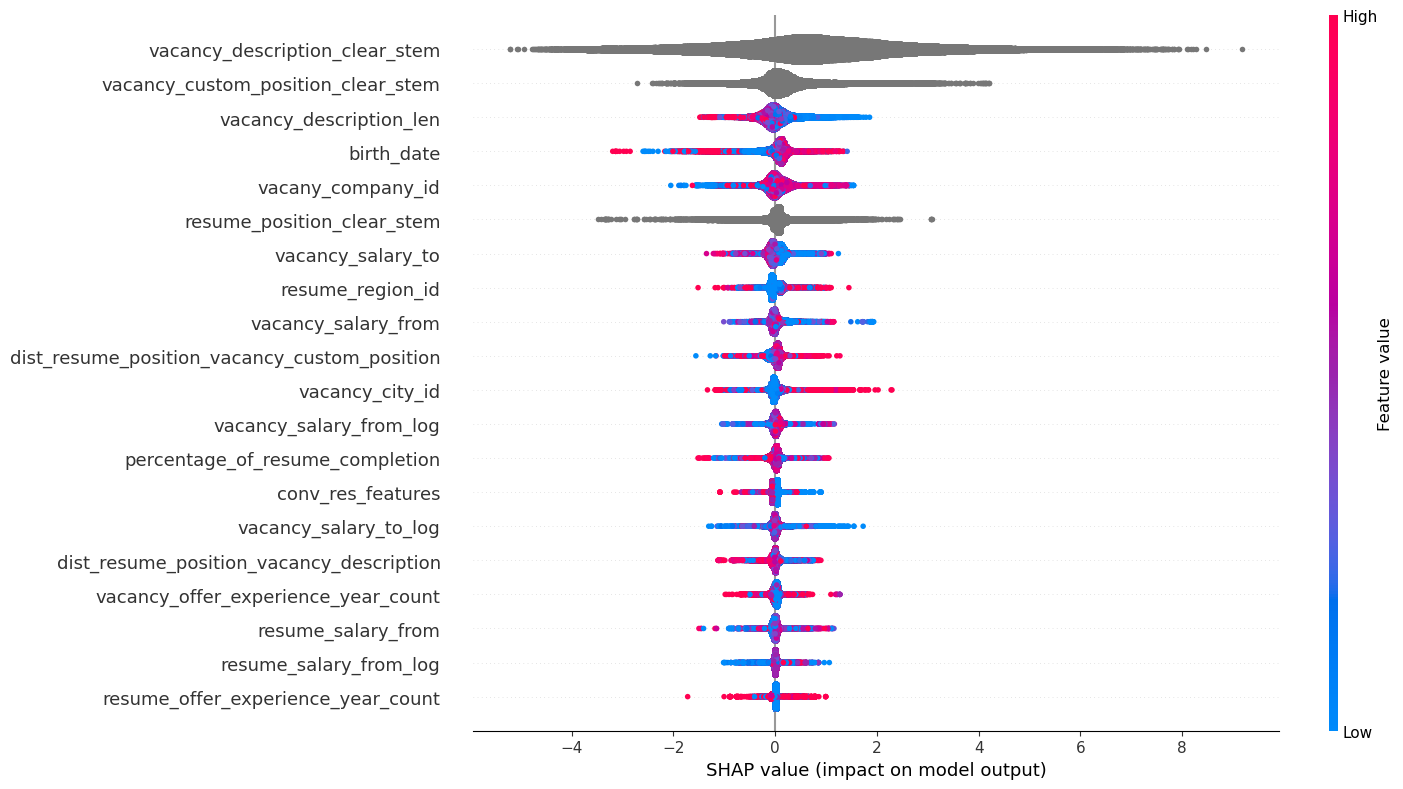

In [18]:
shap_plot(cbc_t2, train_pool_t2, train[X])

Наибольшее влияние оказывают текстовые признаки.  
На тертьем месте - длина текста описания вакансии.
Чем она меньше, тем большее вероятность предсказания положительного решения.

Выведем влияние признаков в численном выражении, полученном внутренними средствами CatBoost.

In [19]:
feature_important_t2 = pd.DataFrame(
    cbc_t2.feature_importances_, cbc_t2.feature_names_, columns=["value"]
).sort_values(by="value", ascending=False)

feature_important_t2

,value
vacancy_description_clear_stem,59.826547
vacancy_custom_position_clear_stem,10.644205
vacancy_description_len,4.792250
resume_position_clear_stem,4.482023
vacany_company_id,4.352170
birth_date,2.559354
vacancy_salary_to,1.404243
vacancy_salary_from,1.201441
vacancy_city_id,1.066404
dist_resume_position_vacancy_custom_position,0.991094


Полученные значения подтверждают полученные ранее выводы.
При этом, существуют признаки, влияние которых на выход модели стремится к нулю.
Исключение таких признаков из модели поможет уменьшить зашумленность данных и повысить целевую метрику.

Проведем перебор первых 30 признаков.

### Оптимизация количества признаков

In [20]:
def plot_valuable_features(feature_important, model, y):
    """
    Функция принимает датафрейм с важностью признаков,
    модель и целевой признак.
    Внутри проходит перебор признаков и обучение модели на них.
    Возвращает график изменения PR AUC.
    """
    sum_importance = []
    pr_auc_s = []
    feature_nums = range(2, 31, 1)

    for valuable_features in tqdm(feature_nums):
        sum_importance.append(feature_important[0:valuable_features].sum()[0])

        X_valuable = feature_important[0:valuable_features].index.tolist()
        cat_features_valuable = [x for x in cat_features if x in X_valuable]
        text_features_valuable = [x for x in text_features if x in X_valuable]

        fit_params_valuable = {
            "cat_features": cat_features_valuable,
            "text_features": text_features_valuable,
        }

        score = cross_val_score(
            model,
            train[X_valuable],
            train[y],
            scoring="average_precision",
            cv=skf,
            fit_params=fit_params_valuable,
        ).mean()

        pr_auc_s.append(score)

    pd.DataFrame(pr_auc_s, list(feature_nums)).plot(legend=None)
    plt.grid(True)
    plt.xlabel("Количество фичей")
    plt.ylabel("PR AUC")
    plt.show()

  0%|          | 0/29 [00:00<?, ?it/s]

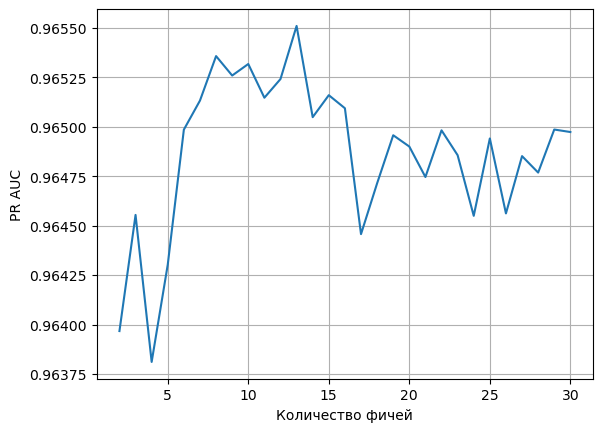

In [21]:
plot_valuable_features(feature_important_t2, cbc_t2, y_2)

По графику - оптимальное число признаков - 8.
Среди них нет ни одного, созданного вручную.

In [22]:
X_t2 = feature_important_t2[0:8].index.tolist()

X_t2

['vacancy_description_clear_stem',
 'vacancy_custom_position_clear_stem',
 'vacancy_description_len',
 'resume_position_clear_stem',
 'vacany_company_id',
 'birth_date',
 'vacancy_salary_to',
 'vacancy_salary_from']

Подберем лучшие гиперпараметры для модели с усеченным набором признаков.

In [23]:
cat_features_t2 = [x for x in cat_features if x in X_t2]
text_features_t2 = [x for x in text_features if x in X_t2]

fit_params_t2 = {"cat_features": cat_features_t2, "text_features": text_features_t2}

study_cb_t2_opt = optuna_cbc(
    X_t2,
    y_2,
    params_init=params_init,
    fit_params=fit_params_t2,
    first_iteration=study_cb_t2_best_params,
)

[I 2023-02-14 02:41:44,711] A new study created in memory with name: no-name-558bc319-2dab-4fb7-82f7-b921c0dbf8de
Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-02-14 02:44:22,602] Trial 0 finished with value: 0.9650626997075624 and parameters: {'learning_rate': 0.5, 'min_data_in_leaf': 1, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 0.9650626997075624.
[I 2023-02-14 02:53:00,019] Trial 1 finished with value: 0.9588261884852566 and parameters: {'learning_rate': 0.27783352240984877, 'min_data_in_leaf': 6, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.9650626997075624.
[I 2023-02-14 02:57:04,323] Trial 2 finished with value: 0.9611921713805085 and parameters: {'learning_rate': 0.6654704506552259, 'min_data_in_leaf': 2, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 0.9650626997075624.
[I 2023-02-14 02:59:48,743] Trial 3 finished with value: 0.9605906884835951 and parameters: {'learning_rate': 0.8662025549398842, 'min_data_in_leaf': 10, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_typ

Опять лучший набор гиперпараметров - начальный.

### Подбор текстовых гиперпараметров

In [24]:
def optuna_text(X, y, previews_params, fit_params, start_params):
    """
    Функция обяъвления функции оптимизации Optuna по перебору минимальному количеству
    используемых токенов для трех словарей: слово, биграм и триграм
    """

    def objective(trial):

        min_token_occurrence_1 = {
            trial.suggest_int("min_token_occurrence_1", 10, 1000, step=10)
        }
        min_token_occurrence_2 = {
            trial.suggest_int("min_token_occurrence_2", 10, 1000, step=10)
        }
        min_token_occurrence_3 = {
            trial.suggest_int("min_token_occurrence_3", 10, 1000, step=10)
        }

        params_optuna = {
            **params_init,
            **previews_params,
            "dictionaries": [
                {
                    "dictionary_id": "Word",
                    "min_token_occurrence ": f"{min_token_occurrence_1}",
                    "max_dictionary_size": "1000000",
                    "gram_order": "1",
                },
                {
                    "dictionary_id": "BiGram",
                    "min_token_occurrence ": f"{min_token_occurrence_2}",
                    "max_dictionary_size": "1000000",
                    "gram_order": "2",
                },
                {
                    "dictionary_id": "3Gram",
                    "min_token_occurrence ": f"{min_token_occurrence_3}",
                    "max_dictionary_size": "1000000",
                    "gram_order": "3",
                },
            ],
            "feature_calcers": [
                "NaiveBayes",
            ],
        }

        cbc_optuna = CatBoostClassifier(**params_optuna, verbose=False)

        return cross_val_score(
            cbc_optuna,
            train[X],
            train[y],
            scoring="average_precision",
            cv=skf,
            fit_params=fit_params,
        ).mean()

    study = optuna.create_study(
        direction="maximize", sampler=optuna.samplers.TPESampler(seed=SEED)
    )

    if start_params:
        study.enqueue_trial(start_params)

    study.optimize(objective, n_trials=10, show_progress_bar=True)

    return study

In [25]:
try:
    study_cb_t2_opt_best_params = study_cb_t2_opt.best_params
except:
    study_cb_t2_opt_best_params = {
        "learning_rate": 0.5,
        "min_data_in_leaf": 1,
        "depth": 6,
        "boosting_type": "Plain",
        "bootstrap_type": "Bayesian",
    }

start_params_text_t2 = {
    "min_token_occurrence_1": 150,
    "min_token_occurrence_2": 480,
    "min_token_occurrence_3": 460,
}

study_cb_t2_opt_text = optuna_text(
    X_t2, y_2, study_cb_t2_opt_best_params, fit_params_t2, start_params_text_t2
)

[I 2023-02-14 03:19:59,896] A new study created in memory with name: no-name-11584618-c0cd-4b58-824b-c368271d0b0c
Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-02-14 03:22:16,111] Trial 0 finished with value: 0.9659109110368277 and parameters: {'min_token_occurrence_1': 150, 'min_token_occurrence_2': 480, 'min_token_occurrence_3': 460}. Best is trial 0 with value: 0.9659109110368277.
[I 2023-02-14 03:24:30,303] Trial 1 finished with value: 0.9661933688504828 and parameters: {'min_token_occurrence_1': 310, 'min_token_occurrence_2': 520, 'min_token_occurrence_3': 770}. Best is trial 1 with value: 0.9661933688504828.
[I 2023-02-14 03:26:44,246] Trial 2 finished with value: 0.9657807839103778 and parameters: {'min_token_occurrence_1': 790, 'min_token_occurrence_2': 880, 'min_token_occurrence_3': 190}. Best is trial 1 with value: 0.9661933688504828.
[I 2023-02-14 03:28:57,483] Trial 3 finished with value: 0.9659614792659342 and parameters: {'min_token_occurrence_1': 270, 'min_token_occurrence_2': 500, 'min_token_occurrence_3': 740}. Best is trial 1 with value: 0.9661933688504828.
[I 2023-02-14 03:31:10,698] Trial 4 finished with value: 0.9

Получено улучшение относительно раннего решения на 0,2% - до 96,62% 

## Задача №1

Добавим в вектор состояния целевой признак по второй задаче и объявим пул.

In [26]:
X = X + y_2

train_pool_t1 = Pool(
    data=train[X],
    label=train[y_1],
    text_features=text_features,
    cat_features=cat_features,
)

In [27]:
cross_val_score(
    cbc_init,
    train[X],
    train[y_1],
    scoring="average_precision",
    cv=skf,
    fit_params=fit_params,
).mean()

0:	learn: 0.6830290	total: 39.9ms	remaining: 39.9s
250:	learn: 0.6490811	total: 6.96s	remaining: 20.8s
500:	learn: 0.6277208	total: 13.7s	remaining: 13.7s
750:	learn: 0.6081923	total: 20.7s	remaining: 6.86s
999:	learn: 0.5898538	total: 27.6s	remaining: 0us
0:	learn: 0.6829022	total: 39.7ms	remaining: 39.7s
250:	learn: 0.6494983	total: 7.07s	remaining: 21.1s
500:	learn: 0.6277604	total: 13.9s	remaining: 13.9s
750:	learn: 0.6094986	total: 20.8s	remaining: 6.89s
999:	learn: 0.5918458	total: 27.8s	remaining: 0us
0:	learn: 0.6829394	total: 35.7ms	remaining: 35.7s
250:	learn: 0.6498230	total: 6.89s	remaining: 20.6s
500:	learn: 0.6283080	total: 13.5s	remaining: 13.5s
750:	learn: 0.6094741	total: 20.1s	remaining: 6.67s
999:	learn: 0.5922111	total: 26.8s	remaining: 0us
0:	learn: 0.6830210	total: 41.5ms	remaining: 41.4s
250:	learn: 0.6501098	total: 7.13s	remaining: 21.3s
500:	learn: 0.6286330	total: 14.2s	remaining: 14.1s
750:	learn: 0.6101614	total: 21.1s	remaining: 6.99s
999:	learn: 0.5932058	

0.5229822915049382

Полученное значение всего на 2,2% лучше случайного.

### Optuna

In [28]:
study_cb_t1 = optuna_cbc(
    X,
    y_1,
    params_init=params_init,
    fit_params=fit_params,
    first_iteration=first_iteration,
)

[I 2023-02-14 03:45:31,110] A new study created in memory with name: no-name-c243fad5-fa5d-49ce-9428-60648ae88999
Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-02-14 03:48:40,751] Trial 0 finished with value: 0.5219581526795748 and parameters: {'learning_rate': 0.5, 'min_data_in_leaf': 1, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 0.5219581526795748.
[I 2023-02-14 03:57:16,799] Trial 1 finished with value: 0.5239211853731288 and parameters: {'learning_rate': 0.27783352240984877, 'min_data_in_leaf': 6, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 1 with value: 0.5239211853731288.
[I 2023-02-14 04:01:40,163] Trial 2 finished with value: 0.5272297031723998 and parameters: {'learning_rate': 0.6654704506552259, 'min_data_in_leaf': 2, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian'}. Best is trial 2 with value: 0.5272297031723998.
[I 2023-02-14 04:05:25,172] Trial 3 finished with value: 0.5199151477840006 and parameters: {'learning_rate': 0.8662025549398842, 'min_data_in_leaf': 10, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_typ

Результат подбора гиперпараметра - PR AUC на кроссвалидации = 52,7% (на 0,5% лучше начального).  

### Shap

In [29]:
try:
    study_cb_t1_best_params = study_cb_t1.best_params
except:
    study_cb_t1_best_params = {
        "learning_rate": 0.5048042274092479,
        "min_data_in_leaf": 9,
        "depth": 2,
        "boosting_type": "Plain",
        "bootstrap_type": "Bernoulli",
    }

In [30]:
params_cb_t1 = {
    **params_init,
    **study_cb_t1_best_params,
}

cbc_t1 = CatBoostClassifier(**params_cb_t1, verbose=False)

cbc_t1.fit(train_pool_t1)

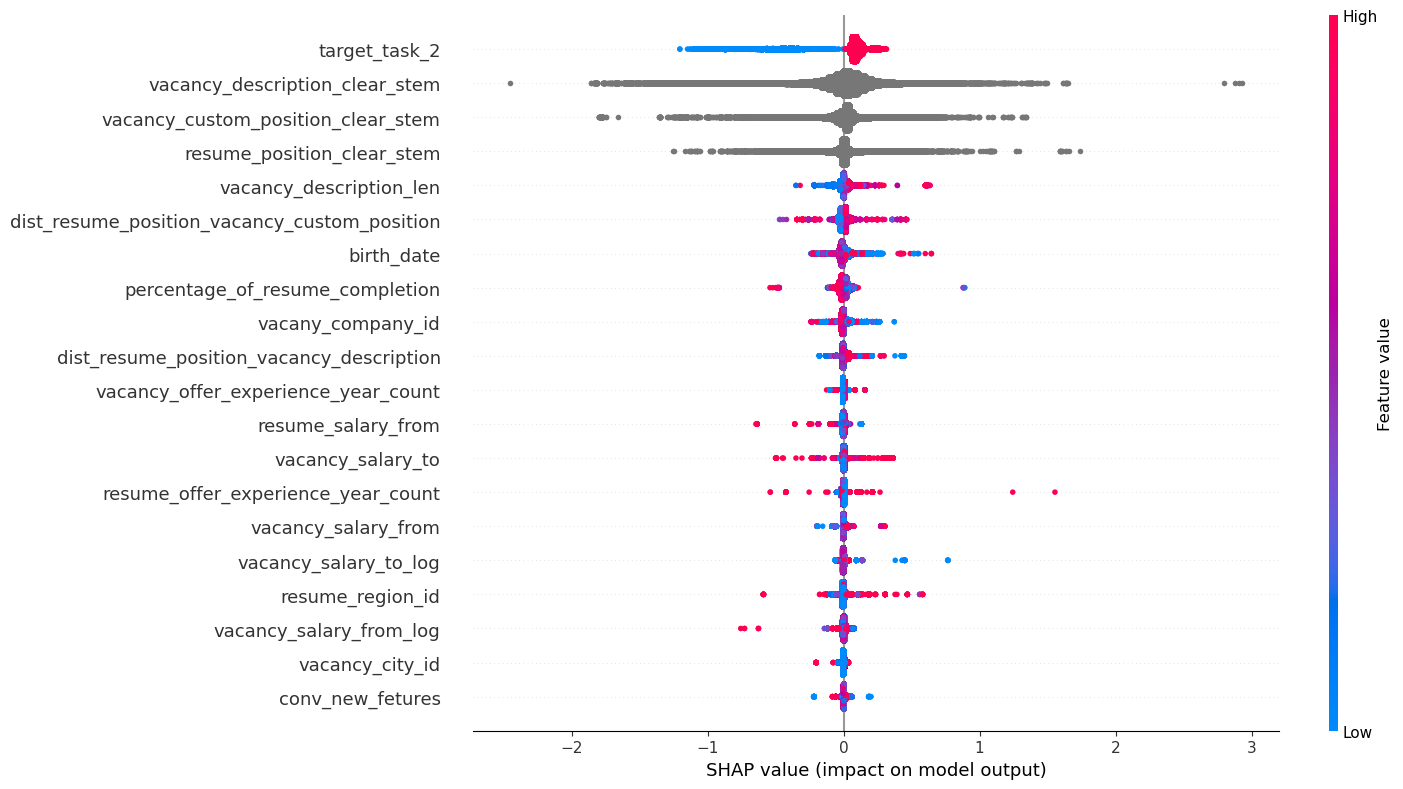

In [31]:
shap_plot(cbc_t1, train_pool_t1, train[X])

Наибольшее влияние оказывают текстовые признаки, целевой признак по второй задаче и нижняя граница вилки в логарифмическом масштабе.
Остальные признаки практически не выделяются. 

In [32]:
feature_important_t1 = pd.DataFrame(
    cbc_t1.feature_importances_, cbc_t1.feature_names_, columns=["value"]
).sort_values(by="value", ascending=False)

feature_important_t1

,value
vacancy_description_clear_stem,38.688885
target_task_2,29.973382
vacancy_custom_position_clear_stem,15.935052
resume_position_clear_stem,7.720750
vacancy_description_len,1.171858
dist_resume_position_vacancy_custom_position,0.795871
birth_date,0.791687
percentage_of_resume_completion,0.693641
vacancy_salary_to,0.567839
vacany_company_id,0.515539


Полученные значения подтверждают полученные ранее выводы.
При этом, существуют признаки, влияние которых на выход модели стремится к нулю.

Проведем перебор первых 30 признаков.

### Оптимизация количества признаков

  0%|          | 0/29 [00:00<?, ?it/s]

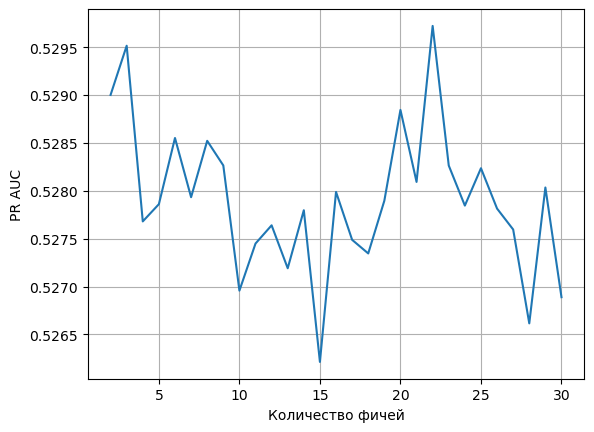

In [33]:
plot_valuable_features(feature_important_t1, cbc_t1, y_1)

По графику - оптимальное число признаков - 3.
Среди них нет ни одного, созданного вручную.

In [34]:
X_t1 = feature_important_t1[0:3].index.tolist()
X_t1

['vacancy_description_clear_stem',
 'target_task_2',
 'vacancy_custom_position_clear_stem']

In [35]:
cat_features_t1 = [x for x in cat_features if x in X_t1]
text_features_t1 = [x for x in text_features if x in X_t1]

fit_params_t1 = {"cat_features": cat_features_t1, "text_features": text_features_t1}

study_cb_t1_opt = optuna_cbc(
    X_t1,
    y_1,
    params_init=params_init,
    fit_params=fit_params_t1,
    first_iteration=study_cb_t1_best_params,
)

[I 2023-02-14 05:21:40,038] A new study created in memory with name: no-name-438cdad3-b9d4-4d2d-9740-626f4d58e7d6
Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-02-14 05:23:10,019] Trial 0 finished with value: 0.5284287912325987 and parameters: {'learning_rate': 0.5048042274092479, 'min_data_in_leaf': 9, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 0.5284287912325987.
[I 2023-02-14 05:29:36,794] Trial 1 finished with value: 0.5236685173269006 and parameters: {'learning_rate': 0.27783352240984877, 'min_data_in_leaf': 6, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.5284287912325987.
[I 2023-02-14 05:32:57,353] Trial 2 finished with value: 0.5275313074889993 and parameters: {'learning_rate': 0.6654704506552259, 'min_data_in_leaf': 2, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 0.5284287912325987.
[I 2023-02-14 05:35:17,325] Trial 3 finished with value: 0.521667317179517 and parameters: {'learning_rate': 0.8662025549398842, 'min_data_in_leaf': 10, 'depth': 7, 'boosting_type': 'Plain',

Целевая метрика увеличилась до 53%.

In [36]:
try:
    study_cb_t1_opt_best_params = study_cb_t1_opt.best_params
except:
    study_cb_t1_opt_best_params = {
        "learning_rate": 0.5048042274092479,
        "min_data_in_leaf": 9,
        "depth": 2,
        "boosting_type": "Plain",
        "bootstrap_type": "Bernoulli",
    }

### Подбор текстовых гиперпараметров

In [53]:
try:
    study_cb_t1_opt_best_params = study_cb_t1_opt.best_params
except:
    study_cb_t1_opt_best_params = {
        "learning_rate": 0.5,
        "min_data_in_leaf": 1,
        "depth": 6,
        "boosting_type": "Plain",
        "bootstrap_type": "Bayesian",
    }

start_params_text_t1 = {
    "min_token_occurrence_1": 10,
    "min_token_occurrence_2": 10,
    "min_token_occurrence_3": 10,
}

study_cb_t1_opt_text = optuna_text(
    X_t1, y_1, study_cb_t1_opt_best_params, fit_params_t1, start_params_text_t1
)

[I 2023-02-14 21:06:19,158] A new study created in memory with name: no-name-9ee1f3ff-37f3-4c48-bae0-491675150766
Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-02-14 21:09:01,583] Trial 0 finished with value: 0.5285989346811645 and parameters: {'min_token_occurrence_1': 10, 'min_token_occurrence_2': 10, 'min_token_occurrence_3': 10}. Best is trial 0 with value: 0.5285989346811645.
[I 2023-02-14 21:11:43,945] Trial 1 finished with value: 0.5286752465282927 and parameters: {'min_token_occurrence_1': 310, 'min_token_occurrence_2': 520, 'min_token_occurrence_3': 770}. Best is trial 1 with value: 0.5286752465282927.
[I 2023-02-14 21:14:24,419] Trial 2 finished with value: 0.5283736729561905 and parameters: {'min_token_occurrence_1': 790, 'min_token_occurrence_2': 880, 'min_token_occurrence_3': 190}. Best is trial 1 with value: 0.5286752465282927.
[I 2023-02-14 21:17:06,868] Trial 3 finished with value: 0.5283955505312534 and parameters: {'min_token_occurrence_1': 270, 'min_token_occurrence_2': 500, 'min_token_occurrence_3': 740}. Best is trial 1 with value: 0.5286752465282927.
[I 2023-02-14 21:19:49,216] Trial 4 finished with value: 0.5283

Целевая метрика увеличилась до 52,89%.

## Test

In [49]:
# Итоговый обучающий пул для второй задачи
train_pool_t2_best = Pool(
    data=train[X_t2],
    label=train[y_2],
    text_features=text_features_t2,
    cat_features=cat_features_t2,
)

# Лучшие текстовые параметры
min_token_occurrence_1 = study_cb_t2_opt_text.best_params["min_token_occurrence_1"]
min_token_occurrence_2 = study_cb_t2_opt_text.best_params["min_token_occurrence_2"]
min_token_occurrence_3 = study_cb_t2_opt_text.best_params["min_token_occurrence_3"]

# Лучшие параметры для второй задачи
params_cb_t2_best = {
    **params_init,
    **study_cb_t2_best_params,
    "dictionaries": [
        {
            "dictionary_id": "Word",
            "min_token_occurrence ": f"{min_token_occurrence_1}",
            "max_dictionary_size": "1000000",
            "gram_order": "1",
        },
        {
            "dictionary_id": "BiGram",
            "min_token_occurrence ": f"{min_token_occurrence_2}",
            "max_dictionary_size": "1000000",
            "gram_order": "2",
        },
        {
            "dictionary_id": "3Gram",
            "min_token_occurrence ": f"{min_token_occurrence_3}",
            "max_dictionary_size": "1000000",
            "gram_order": "3",
        },
    ],
    "feature_calcers": [
        "NaiveBayes",
    ],
}

# Обучение модели
cbc_t2_best = CatBoostClassifier(**params_cb_t2_best, verbose=False)

cbc_t2_best.fit(train_pool_t2_best)

In [50]:
# Скопируем целевой признак в новый столбец, чтобы сработало обучение для первой задачи.
test["target_task_2_true"] = test["target_task_2"]

# Предсказания скора для второй задачи
test["target_task_2"] = cbc_t2_best.predict(test[X_t2], prediction_type="Probability")[
    :, 1
]

# Расчет метрики
average_precision_score(test["target_task_2_true"], test["target_task_2"])

0.9687497968388153

Значение на 0,25% выше полученного при кроссвалидации, что говорит о правильности выбранных гиперпараметров.

In [54]:
# Итоговый обучающий пул для второй задачи
train_pool_t1_best = Pool(
    data=train[X_t1],
    label=train[y_1],
    text_features=text_features_t1,
    cat_features=cat_features_t1,
)

# Лучшие параметры для первой задачи
params_cb_t1_best = {
    **params_init,
    **study_cb_t1_best_params,
}

# Обучение модели
cbc_t1_best = CatBoostClassifier(**params_cb_t1_best, verbose=False)

cbc_t1_best.fit(train_pool_t1_best)

In [55]:
# Предсказания скора для первой задачи
test["target_task_1_pred"] = cbc_t1_best.predict(
    test[X_t1], prediction_type="Probability"
)[:, 1]

# Расчет метрики
average_precision_score(test["target_task_1"], test["target_task_1_pred"])

0.5225873455705196

Значение на 0,4% ниже полученного при кроссвалидации, что говорит о переобучении модели.

# Заключение

Разработаны модели машинного обучения для разработки сервиса автоматизации труда рекрутеров в части просмотра и оценки резюме. Модели решают две задачи: предсказание факта отклика соискателя с данным резюме на данную вакансию и предсказание факта приглашения работодателем откликнувшегося соискателя на собеседование.

Для достижения поставленной цели проведен анализ данных, в ходе которого сделано предположение об искусственной стратификации всего датасета по всем признакам. Это проявляется в том, что по всем признакам распределение целевых признаков практически не изменяется и находится на уровне 50/50 для первой задачи и 90/10 - для второй. 

В качестве моделей использованы инструменты библиотеки Catboost. 
Проведен выбор гиперпараметров и анализ важности признаков. 
В ходе последнего получено, что для обеих задач наибольший вклад в качество предсказания оказывают текстовые признаки. 
Качество моделей проверено на тестовой подвыборке датасета с использованием метрики PR AUC. 
Получены следующие значения: 
- для задачи №1 - 52,25%,  
- для задачи №2 - 96,87%.

Полученные значения превосходят случайные модели на 2,25% и 46,87% соответственно. 
В этой связи представляется целесообразным дальнейшие работы по текущему направлению планировать с учетом использования нейронных сетей. 